### Simulation Data Aggregation


In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from lens_simulation import utils
# path = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\duly-fancy-panda\sweet-mako"
pd.set_option("display.max_rows", None, "display.max_columns", None)

directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\barely-ideal-zebra"
directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\lively-vital-duck"


df = utils.load_run_simulation_data(directory)

print(f"run: {os.path.basename(directory)}")
display(df.T)


df.to_csv("data.csv")

In [ ]:
display(df[df["exponent"] ==  2.1].T)


## Simulation Parameter Sweep


In [ ]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils
from pprint import pprint
from copy import deepcopy

# sweep
config = utils.load_config("config.yaml")

config["sweep"] = deepcopy(config)

pprint(config)


# config dict vs config yaml
# yaml creates the sweeps
# dicts create the objects




In [ ]:
%load_ext autoreload
%autoreload 2

%load_ext autoreload 
%autoreload 2
from lens_simulation import SimulationRunner


sim_runner = SimulationRunner.SimulationRunner("sweep.yaml")
# sim_runner.initialise_simulation()
sim_runner.setup_simulation()
# sim_runner.run_simulations()


In [ ]:
%load_ext autoreload
%autoreload 2
from lens_simulation.SimulationRunner import (get_lens_configurations, generate_lens_parameter_combinations, 
    generate_beam_parameter_combinations,  get_beam_configurations, generate_stage_parameter_combination, get_stage_configurations, 
    generate_simulation_parameter_sweep, sweep_custom_profiles)
from lens_simulation import utils
from lens_simulation.constants import LENS_SWEEPABLE_KEYS, MODIFICATION_SWEEPABLE_KEYS, BEAM_SWEEPABLE_KEYS, STAGE_SWEEPABLE_KEYS, GRATING_SWEEPABLE_KEYS, TRUNCATION_SWEEPABLE_KEYS, APERTURE_SWEEPABLE_KEYS
from lens_simulation import validation
from pprint import pprint
from copy import deepcopy


In [ ]:
config = utils.load_config("config.yaml")
info =  {"run_id": 9999, "run_petname": "test-carry-mule", "log_dir": "log"}


lc = config["lenses"][0]

# print("profiles:")
# pprint(lc["custom"])
# print("-"*50)
cp = sweep_custom_profiles(lc["custom"])

# print("custom_params: ", cp)

simulation_configurations = generate_simulation_parameter_sweep(config, info)

for sc in simulation_configurations:
    print("-"*50)
    for lc in sc["lenses"]:
        pprint(lc["custom"])

In [ ]:
from lens_simulation.Lens import generate_lens
from lens_simulation.Medium import Medium
from lens_simulation import utils
import matplotlib.pyplot as plt

for conf in simulation_configurations:

    # pprint(conf)
    lc = conf["lenses"][0]
    lens = generate_lens(lc, Medium(lc["medium"]), conf["sim_parameters"]["pixel_size"])

    plotting.plot_lens_profile_2d(lens)
    plt.show()

    plotting.plot_lens_profile_slices(lens)
    plt.show()



In [ ]:
directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\hugely-subtle-drake"
df = utils.load_run_simulation_data(directory)

display(df.T)

### ZARR


### New Simulation Config


In [ ]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils
from pprint import pprint
from lens_simulation.beam import load_beam_config
from lens_simulation.Simulation import generate_simulation_options, generate_simulation_parameters, load_sim_stage_config
from lens_simulation.structures import SimulationConfig
from lens_simulation.Lens import load_lens_config
config = utils.load_config("sweep.yaml")
# conf_v2 = utils.load_config_struct("sweep.yaml")



In [ ]:

beam_settings = load_beam_config(config["beam"])

lenses = [load_lens_config(lc) for lc in config["lenses"]]
stages = [load_sim_stage_config(sc) for sc in config["stages"]]

options = generate_simulation_options(config, "log")
parameters = generate_simulation_parameters(config)


sim_config = SimulationConfig(
    beam=beam_settings,
    lenses=lenses,
    stages=stages,
    parameters=parameters,
    options=options
)


print("SIM CONFIG:")
pprint(sim_config.beam)
print("-"*50)
pprint(sim_config.lenses)
print("-"*50)
pprint(sim_config.stages)
print("-"*50)
pprint(sim_config.parameters)
print("-"*50)
pprint(sim_config.options)



### DASK Experiments


In [ ]:
import time
import dask


@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1

@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [ ]:
%%time

a = inc(1)
b = inc(1)
c = add(a, b)
c.visualize("mydask.png")
# c.dask
# c = c.compute()


In [ ]:
## ZARR

In [ ]:
import zarr
z = zarr.zeros((10000, 10000), chunks=(1000, 1000), dtype='i4')
print(z.info)

z1 = zarr.open('data/example.zarr', mode='w', shape=(10000, 10000), chunks=(1000, 1000), dtype='i4')

import numpy as np
a = np.arange(10)
zarr.save('data/example.zarr', a)
zarr.load('data/example.zarr')

In [ ]:


def save_simulation_zarr(arr, fname):
    print("saving zarr")
    zarr.save(fname, arr)

def load_simulation_zarr(fname):
    print("loading zarr")
    arr = zarr.open(fname)
    return arr

In [ ]:
fname = "data/zarr_test.zarr"


# sim = zarr.zeros(shape=(100, 10000, 10000), dtype=np.float32)
sim = zarr.zeros(shape=(10, 501, 501), chunks=(100, 100), dtype=np.float32)
save_simulation_zarr(sim, fname)

# TODO: why doesnt this open work for slicing?
# sim = zarr.open(fname, mode="w", shape=(100, 10000, 10000), chunks=(1000, 1000), dtype=np.float32)



In [ ]:
# arr = zarr.load(fname)  # load as np, bad

In [ ]:
# sim = load_simulation_zarr(fname)

print(sim.shape)
print(type(sim))

cy, cx = sim.shape[1] // 2, sim.shape[2] //2
import matplotlib.pyplot as plt
plt.imshow(sim[:, cy, :])
plt.show()


In [ ]:

ones = np.ones(shape=(sim.shape[1], sim.shape[2]))

sweep = np.outer(np.arange(sim.shape[1]), np.arange(sim.shape[1]).T)

plt.imshow(sweep)
plt.show()

print(ones.shape)


In [ ]:

for i in range(sim.shape[0]):
    print("step: ", i)
    sim[i, :, :] = sweep * i



In [ ]:
cy

cw = 500

fig = plt.figure(figsize=(12, 5))
plt.imshow(sim[:, cw-100:cw+100, 500])
plt.colorbar()
plt.show()

# # cx
plt.imshow(sim[:, 500, cx-100:cx+100])
plt.colorbar()
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from lens_simulation import utils 


fname = "data/example.npy"
arr = np.ones(shape=(100, 100))

arr = np.pad(arr, 20, mode="constant", constant_values=0)
np.save(fname, arr)

ap_fname = "data/example.aperture.npy"

distance = utils.create_distance_map_px(arr.shape[1], arr.shape[0])

ap = distance > 10
plt.imshow(ap)
plt.show()

np.save(ap_fname, ap)


arr2 = np.load(fname)

plt.imshow(arr2)
plt.colorbar()
plt.show()


In [ ]:
import os
import glob

from lens_simulation.SimulationRunner import sweep_custom_profiles

profs = sweep_custom_profiles(os.path.dirname(fname))
print(profs)



In [ ]:
from lens_simulation.Lens import load_aperture, generate_lens
from lens_simulation.Medium import Medium
        
config = utils.load_config("config.yaml")

# config["lenses"][0]["custom"] = "data/subdir/example2.npy"
config["lenses"][0]["custom"] = "data/example.npy"


lens = generate_lens(config["lenses"][0], Medium(1), pixel_size=1.e-6)

plt.imshow(lens.profile)
plt.show()

plt.imshow(lens.aperture)
plt.show()


## Update GIF Functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Lossy conversion from float32 to uint8. Range [0.0, 10000.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [8.041000000957865e-06, 17763.41015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002165878191590309, 22351.25390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.009031305089592934, 30131.544921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.027524664998054504, 39250.98046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.01247981283813715, 52905.11328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00016590490122325718, 82253.6484375]. Convert image to uint8 prior t

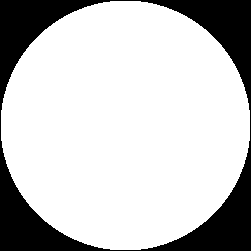

In [109]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from IPython.display import Image
import imageio

path = r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\vastly-master-orca\stable-stag\1/sim.zarr"

plotting.save_propagation_gif(path)
 
Image(os.path.join(os.path.dirname(path), "propagation.gif"))
